In [4]:
# prompt: Need help in deriving PCA for a dataset. I need sample code. Also, I would like to use the dataset LuFlow which is available in my Google Drive. I think I need to do data engineering on the dataset. Can you give the step by step example and the code accordingly?
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [6]:
### To check whether GPU is used.
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available and being used.")
    print("GPU Details:", gpu_available)
else:
    print("GPU is not available. Using CPU.")

GPU is available and being used.
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
from IPython.display import Image
import os, datetime

In [8]:
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

In [9]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report,roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [10]:
from google.colab import drive
drive.mount('/content/drive')
# Define the file path to your dataset in Google Drive
#file_path = '/content/drive/MyDrive/LuFlow.csv'
#file_path = '/content/drive/MyDrive/VIT/Dataset/LuFlow2021/luflow.csv'


Mounted at /content/drive


In [11]:
file_1 = '/content/drive/MyDrive/VIT/Dataset/UNSW_NB15/UNSW-NB15_training-set.csv'
file_2 = '/content/drive/MyDrive/VIT/Dataset/UNSW_NB15/UNSW-NB15_training-set.csv'

# Read the CSV files back into pandas DataFrames
df1 = pd.read_csv(file_1)
df2 = pd.read_csv(file_2)

# Concatenate the DataFrames
df = pd.concat([df1, df2], ignore_index=True)

# Optional: Display the first few rows and shape to verify they are loaded correctly
print("First 5 rows:")
print(df.head())
print("\nShape:")
print(df.shape)

First 5 rows:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0       

In [12]:
# Access the dtypes attribute
feature_data_types = df.dtypes

# Print the data types
print("Data Types of Features:")
print(feature_data_types)

Data Types of Features:
id                     int64
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm         

In [13]:
#Get the counts of each unique label
label_counts = df['label'].value_counts()

#Print the results

print("\nCounts of Each Label:")
print(label_counts)


Counts of Each Label:
label
1    238682
0    112000
Name: count, dtype: int64


In [14]:
df = shuffle(df)

In [15]:
def dropInfNull(df):
    print (df.shape)

    # replace infinity value as null value
    df = df.replace(["Infinity", "infinity"], np.inf)
    df = df.replace([np.inf, -np.inf], np.nan)

    # drop all null values
    df.dropna(inplace=True)

    print ("Shape after dropInfNull:", df.shape)

    # --- Added checks after the function runs ---
    if df.isnull().sum().sum() > 0:
        print("WARNING: NaNs found in DataFrame after dropInfNull.")
        print("NaNs per column:\n", df.isnull().sum()[df.isnull().sum() > 0])

    # Check for infinities only in numeric columns
    numeric_df = df.select_dtypes(include=np.number)

    if np.isinf(numeric_df).sum().sum() > 0:
         print("WARNING: Infinities found in DataFrame after dropInfNull in numeric columns.")
         # np.isinf returns boolean array, sum along axes or flatten for total
         inf_counts = np.isinf(numeric_df).sum()
         print("Infinities per column:\n", inf_counts[inf_counts > 0])
    # --- End added checks ---

    return df

In [16]:
%%time
df = dropInfNull(df)

(350682, 45)
Shape after dropInfNull: (350682, 45)
CPU times: user 655 ms, sys: 98.3 ms, total: 753 ms
Wall time: 749 ms


In [17]:
convert_columns = list(df.select_dtypes(include=['category','object']).columns)
convert_columns

['proto', 'service', 'state', 'attack_cat']

In [18]:
# initialize LabelEncoder
label_encoder = LabelEncoder()

# convert
for column in convert_columns:
    df[column] = label_encoder.fit_transform(df[column])

**Drop Constant Column**

In [20]:
%%time
# drop the constant columns (which varience is 0)
variances = df.var(numeric_only=True)
constant_columns = variances[variances == 0].index
df = df.drop(constant_columns, axis=1)

print(constant_columns)
print (df.shape)

Index([], dtype='object')
(350682, 45)
CPU times: user 74.9 ms, sys: 14.2 ms, total: 89.1 ms
Wall time: 88.6 ms


**Drop Duplicate Column**

In [21]:
duplicates = set()
for i in range(0, len(df.columns)):
    col1 = df.columns[i]
    for j in range(i+1, len(df.columns)):
        col2 = df.columns[j]
        if(df[col1].equals(df[col2])):
            duplicates.add(col2)

print (duplicates)
df.drop(duplicates, axis=1, inplace=True)
print (df.shape)

{'ct_ftp_cmd'}
(350682, 44)


**Drop Columns based on correlation**

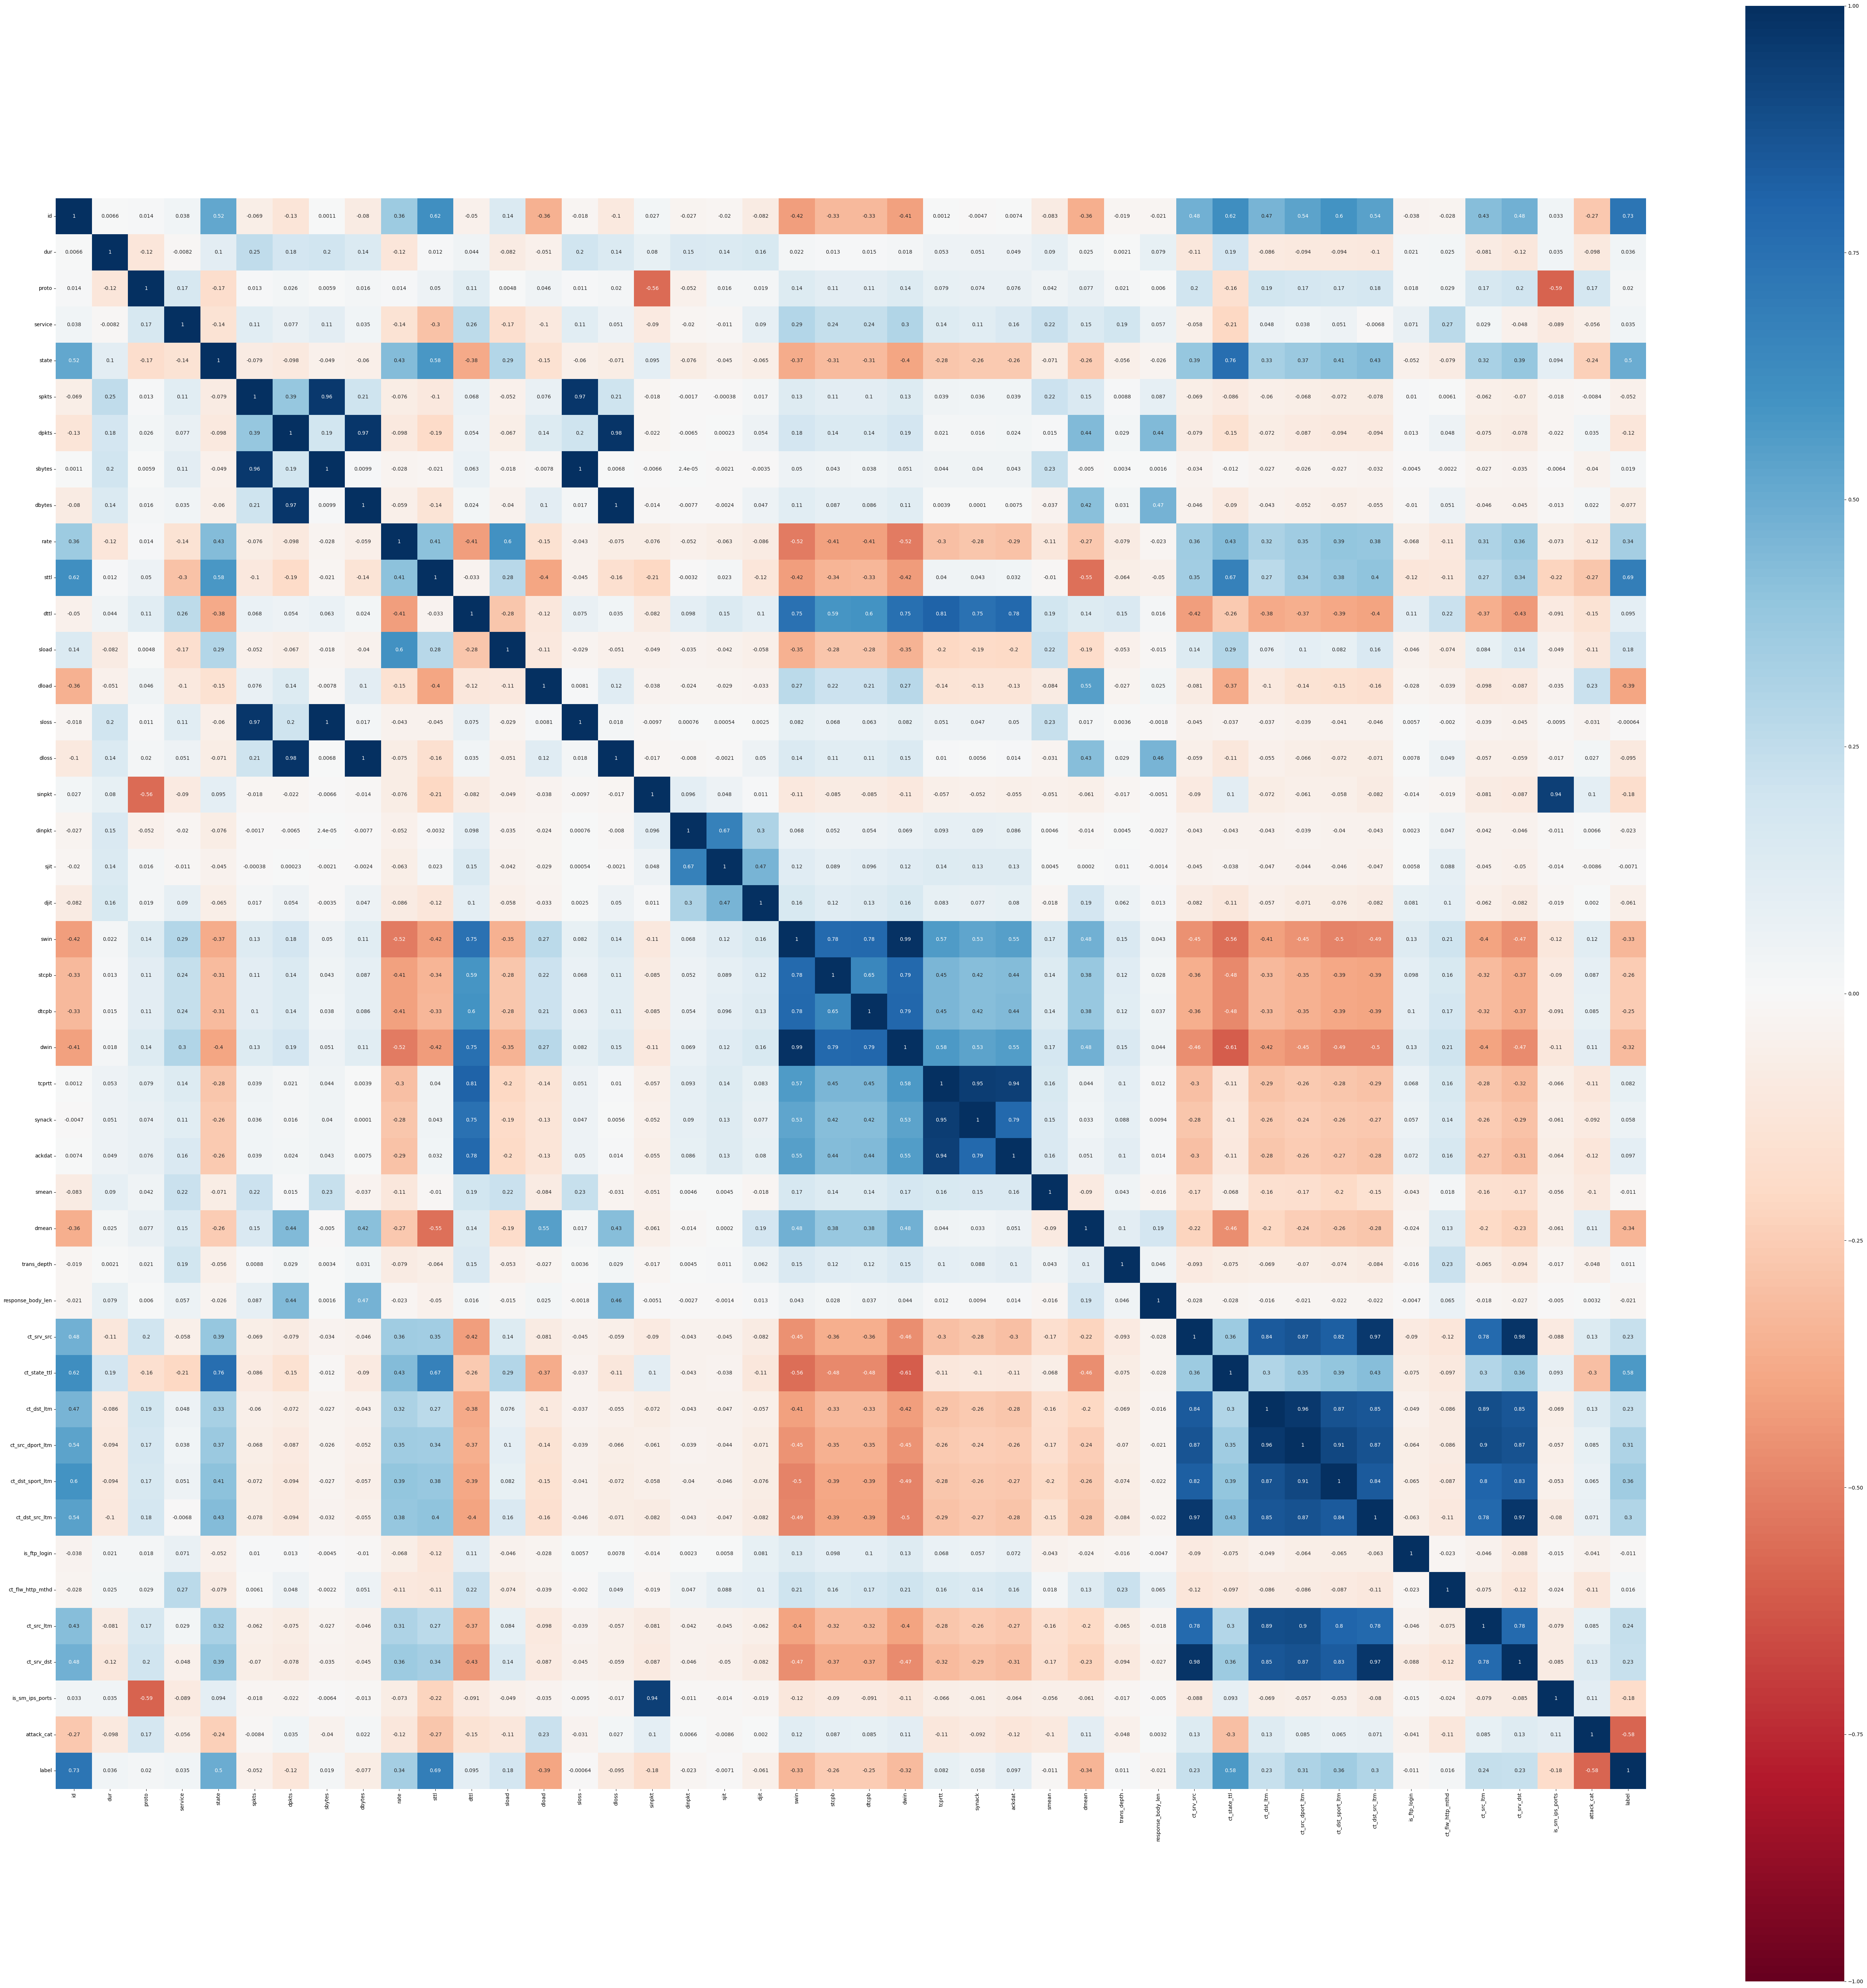

CPU times: user 5.88 s, sys: 246 ms, total: 6.13 s
Wall time: 6.11 s


In [22]:
%%time
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

In [23]:
%%time
correlated_col = set()
is_correlated = [True] * len(corr.columns)
threshold = 0.90
for i in range (len(corr.columns)):
    if(is_correlated[i]):
        for j in range(i):
          if (corr.iloc[i, j] >= threshold) and (is_correlated[j]):
            colname = corr.columns[j]
            is_correlated[j]=False
            correlated_col.add(colname)

print(correlated_col)
print(len(correlated_col))

{'ct_dst_ltm', 'dpkts', 'dbytes', 'ct_src_dport_ltm', 'sinpkt', 'sbytes', 'swin', 'ct_srv_src', 'tcprtt', 'spkts', 'ct_dst_src_ltm'}
11
CPU times: user 17.3 ms, sys: 940 µs, total: 18.2 ms
Wall time: 18 ms


In [24]:
%%time
df.drop(correlated_col, axis=1, inplace=True)
print (df.shape)

(350682, 33)
CPU times: user 16.8 ms, sys: 12.3 ms, total: 29.1 ms
Wall time: 28.5 ms


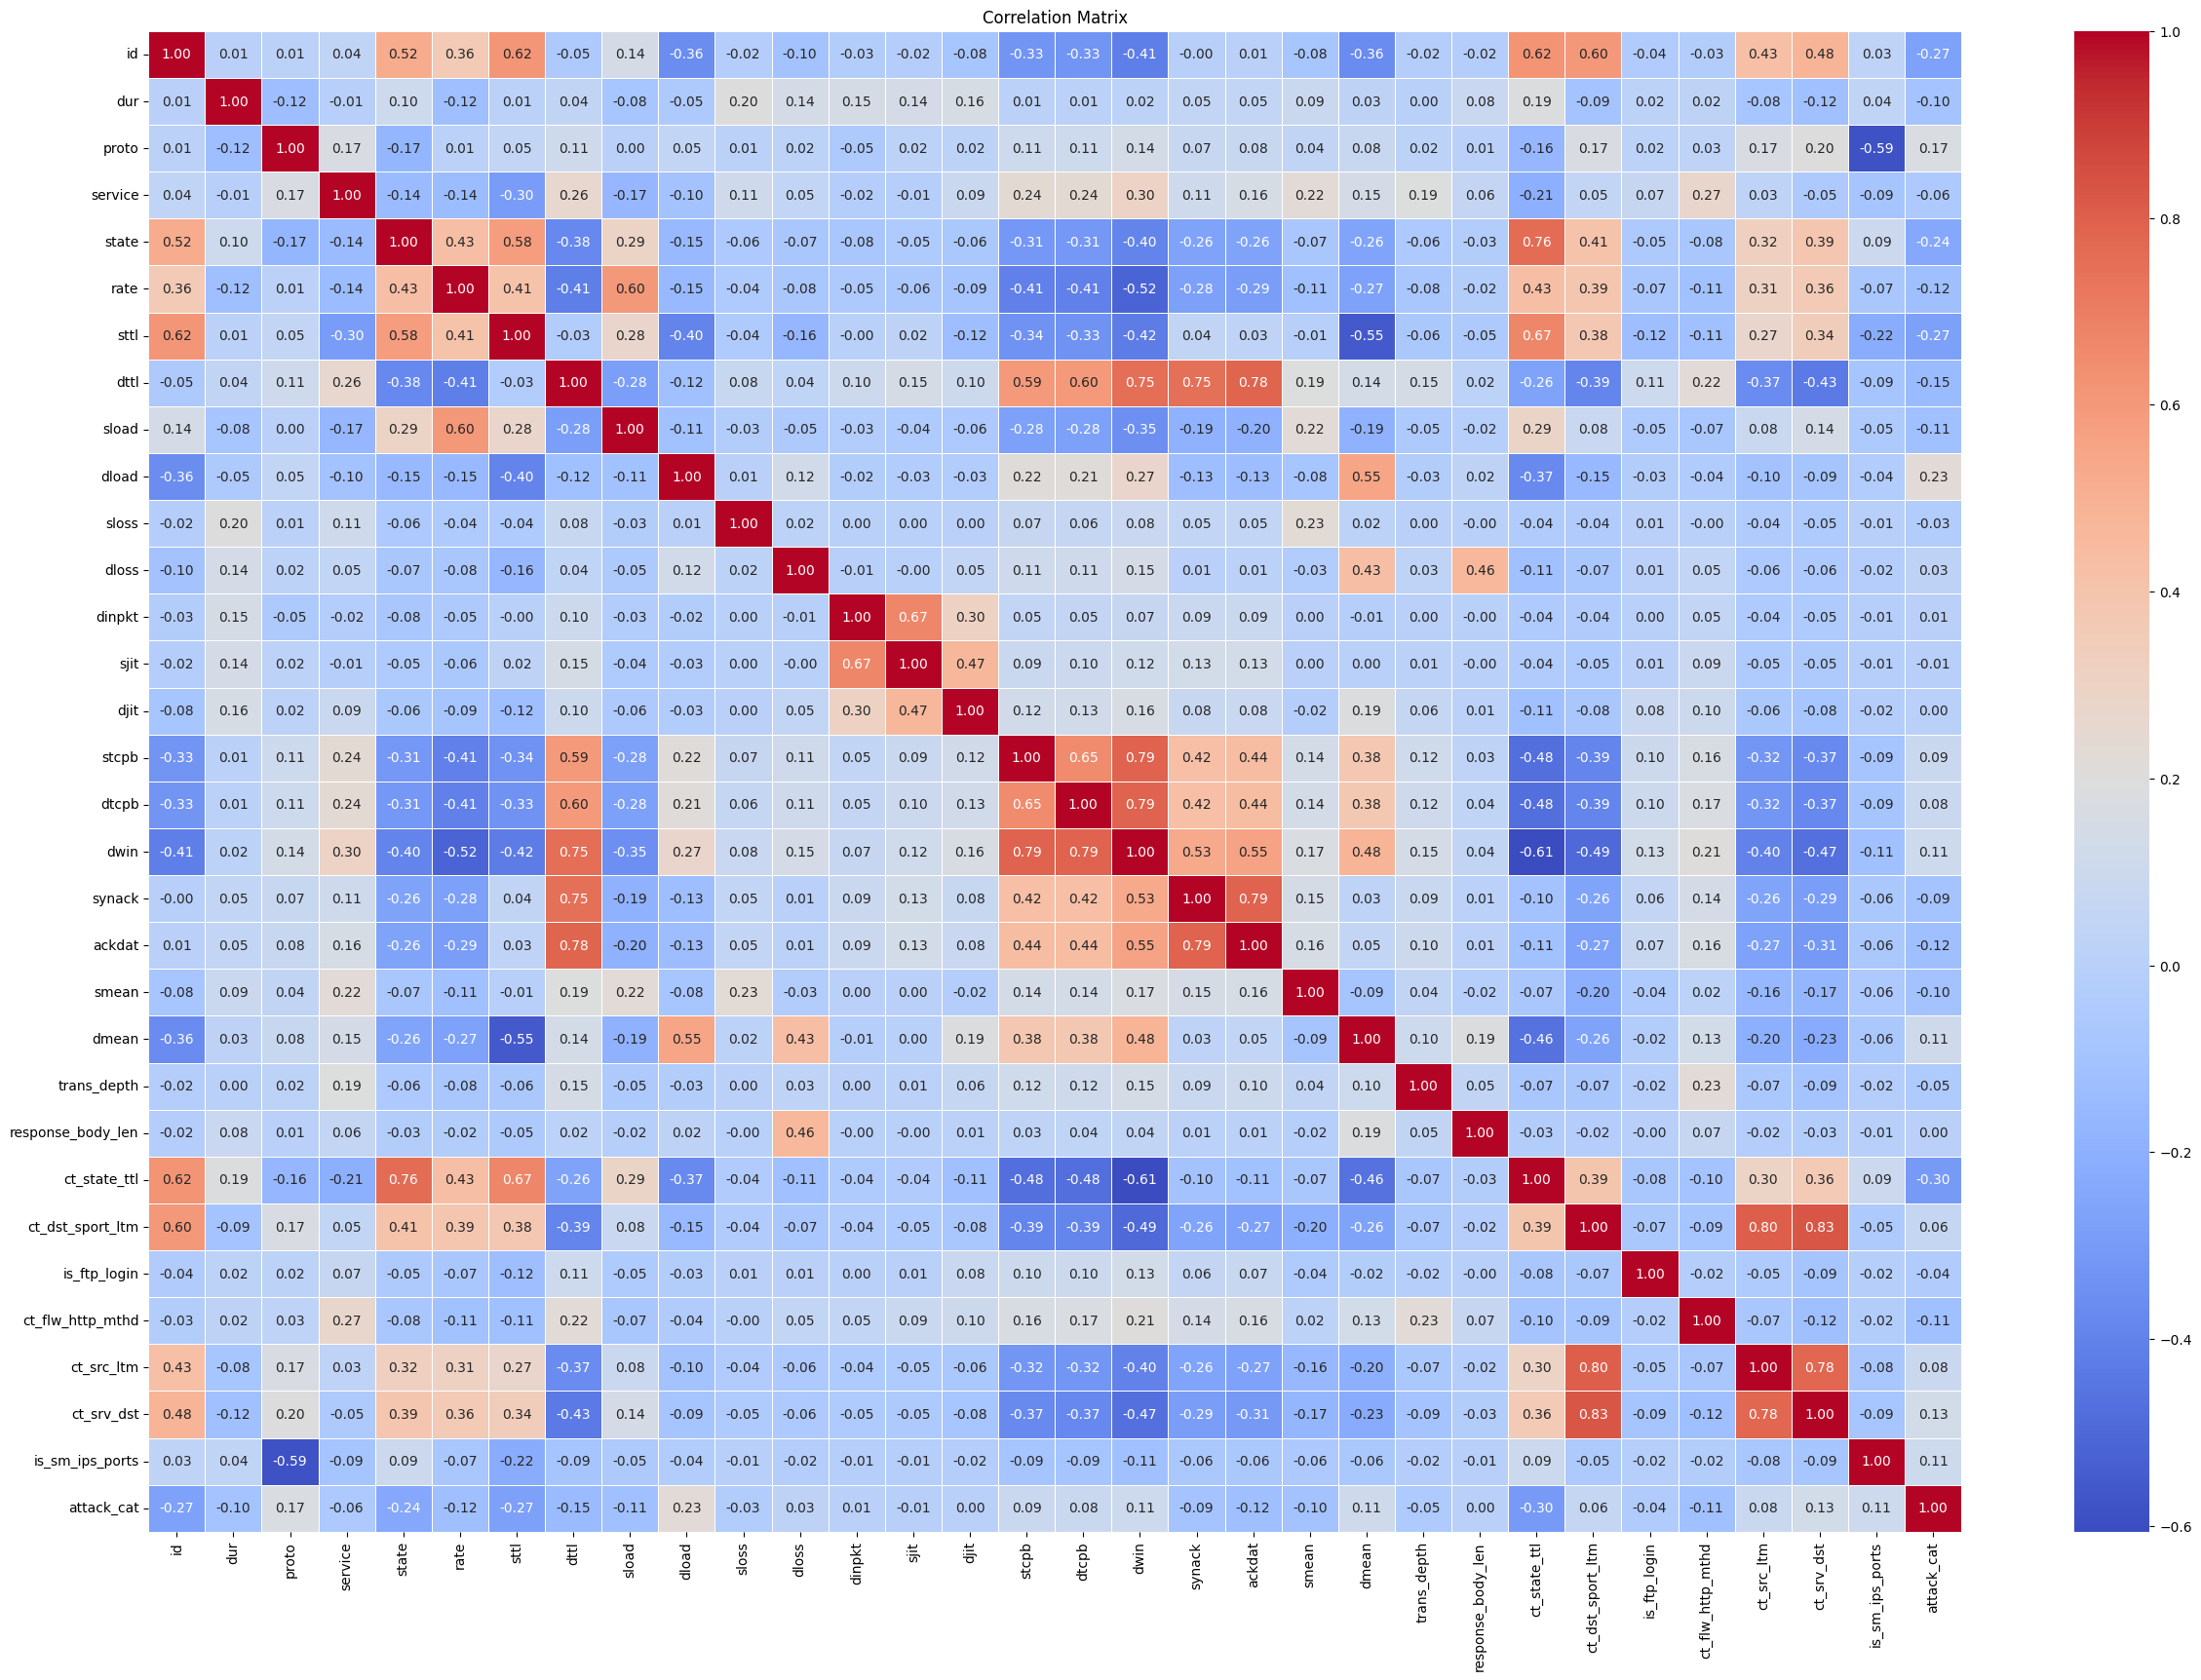

In [25]:
# Calculate correlation matrix
correlation_matrix = df.drop('label', axis=1).corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

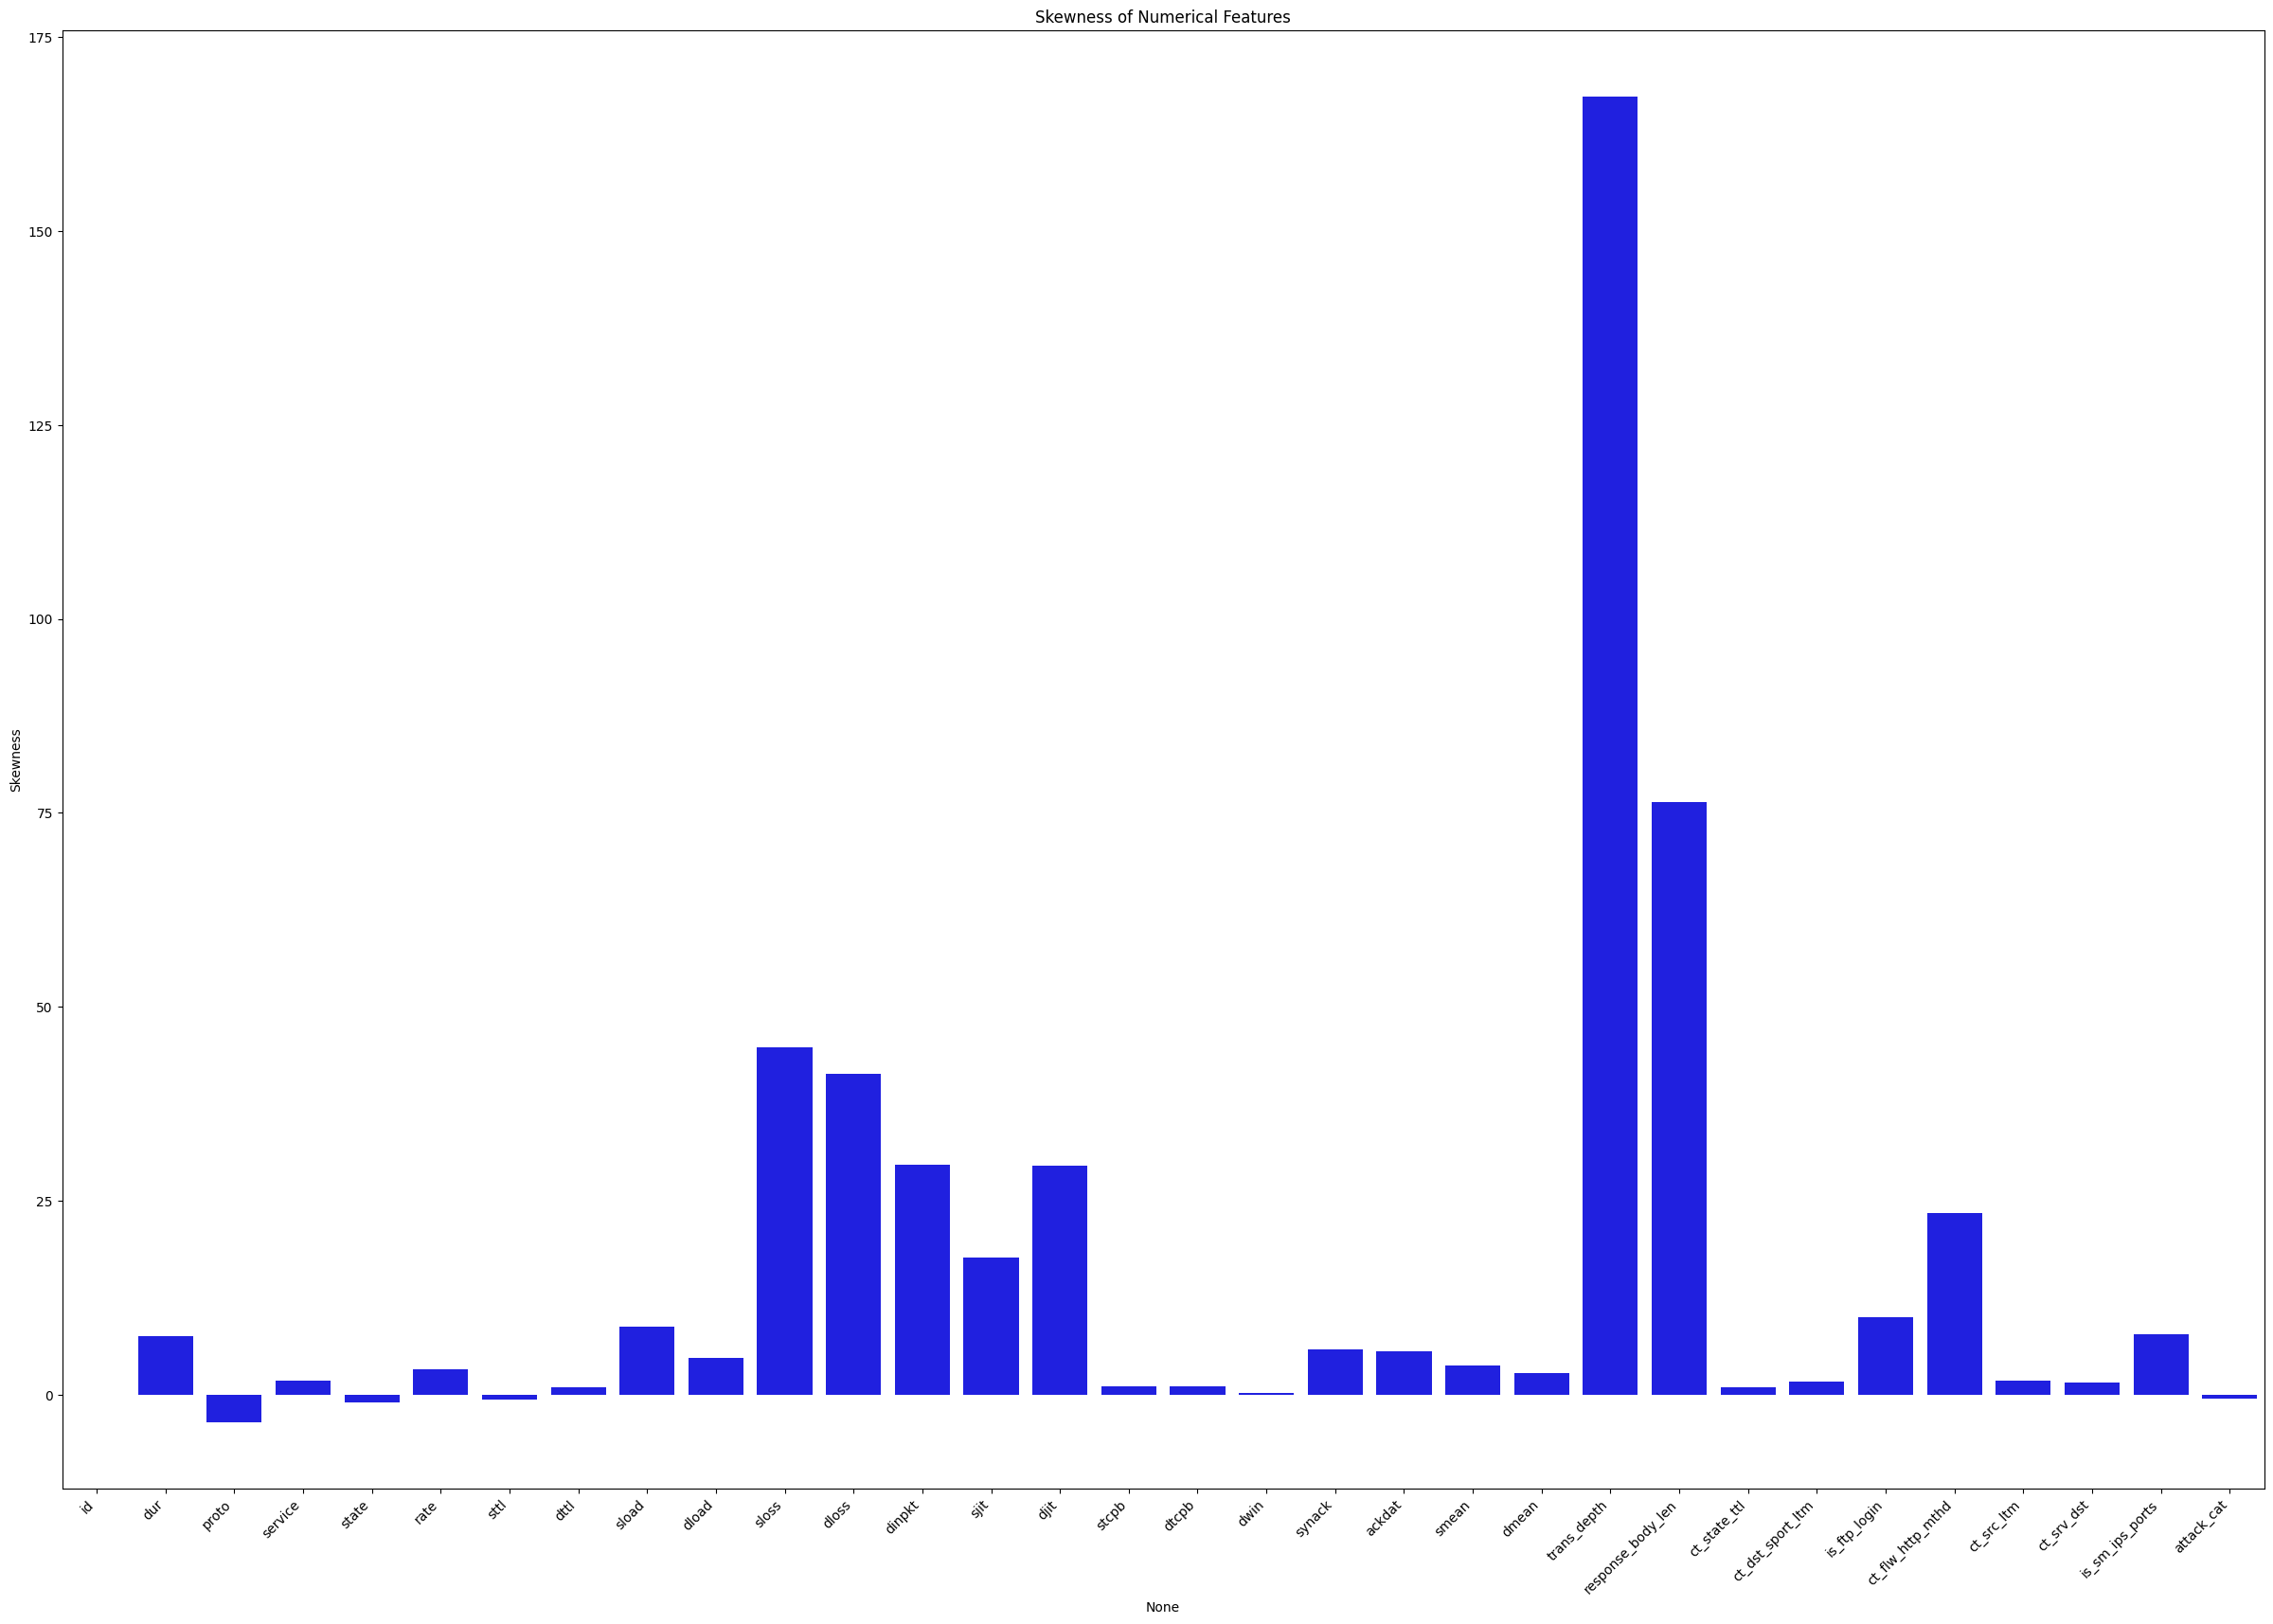

In [26]:
# Calculate skewness for each numerical column
skewness = df.drop('label', axis=1).skew()

# Create a bar plot or a histogram of skewness values
plt.figure(figsize=(30, 20))
sns.barplot(x=skewness.index, y=skewness.values, color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Skewness of Numerical Features')
plt.ylabel('Skewness')
plt.show()

In [27]:
X = df.drop('label', axis=1)
y = df['label']

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Perform oversampling
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with oversampled data
final_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='label')], axis=1)

In [28]:
attackcat_counts = final_df['label'].value_counts()
attackcat_counts

,count
label,
1,238682
0,238682


In [29]:
X = final_df.drop('label', axis=1)
y = final_df['label']

In [27]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training set
X_scaled = scaler.fit_transform(X)

X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data (using the reshaped data)
x_train, x_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, shuffle=True)

In [29]:
print("Before split NaNs in X:", X.isnull().sum().sum())
print("After split NaNs in x_train:", np.isnan(x_train).sum())

Before split NaNs in X: 0
After split NaNs in x_train: 0


In [30]:
# Split the data first (before scaling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training set
scaler.fit(X_train)

# Transform both the training and test sets using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the scaled data for LSTM
x_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
x_test = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [31]:
# --- Build the LSTM Model ---

# Define the model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])), # LSTM layer
    Dropout(0.3),
    LSTM(32), # Another LSTM layer, return_sequences=False for the last LSTM layer
    Dropout(0.3),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# Compile the model
model_lstm.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=[tf.keras.metrics.AUC(name='auc')])

# Print model summary
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,281 (145.63 KB)

 Trainable params: 37,281 (145.63 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# --- Train the LSTM Model ---

# Calculate balance_weight if needed (similar to your MLP)
benign_count = y_train.value_counts()[0]
anomaly_count = y_train.value_counts()[1]
balance_weight = benign_count / anomaly_count if anomaly_count > 0 else 1.0
class_weights = {0: 1, 1: balance_weight}

print(f"Balance Weight: {balance_weight}")

Balance Weight: 0.9995340070160741


In [34]:
history_lstm = model_lstm.fit(x_train, y_train,
                              epochs=50, # Adjust epochs
                              batch_size=256, # Adjust batch size
                              validation_split=0.2,
                              class_weight=class_weights,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])


Epoch 1/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - auc: 0.9793 - loss: 0.1923 - val_auc: 1.0000 - val_loss: 0.0030
Epoch 2/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 1.0000 - loss: 0.0037 - val_auc: 1.0000 - val_loss: 3.4429e-04
Epoch 3/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 1.0000 - loss: 8.0113e-04 - val_auc: 1.0000 - val_loss: 6.8201e-05
Epoch 4/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 1.0000 - loss: 3.5635e-04 - val_auc: 1.0000 - val_loss: 1.5120e-05
Epoch 5/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 1.0000 - loss: 1.9618e-04 - val_auc: 1.0000 - val_loss: 5.2889e-06
Epoch 6/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 1.0000 - loss: 9.1775e-05 - val_auc: 1.0000 - val_loss: 1.2931e-05
Epoch 7/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 1.0000 - loss: 8.2928e-05 - val_auc: 1.0000 - val_loss: 2.9418e-06
Epoch 8/50
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 1.0000 - loss: 1.9973e-04 - val_auc: 1.0000 - val_loss

In [35]:
# --- Evaluate the LSTM Model ---

loss_lstm, auc_lstm = model_lstm.evaluate(x_test, y_test, verbose=0)
print(f"--- LSTM Classifier ---")
print(f"Test AUC: {auc_lstm:.4f}")

--- LSTM Classifier ---
Test AUC: 1.0000


In [36]:
# Get predictions and probabilities
y_pred_proba_lstm = model_lstm.predict(x_test).ravel()
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_lstm))

2984/2984 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     47781
           1       1.00      1.00      1.00     47692

    accuracy                           1.00     95473
   macro avg       1.00      1.00      1.00     95473
weighted avg       1.00      1.00      1.00     95473



In [37]:
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_lstm))

ROC AUC Score:
1.0


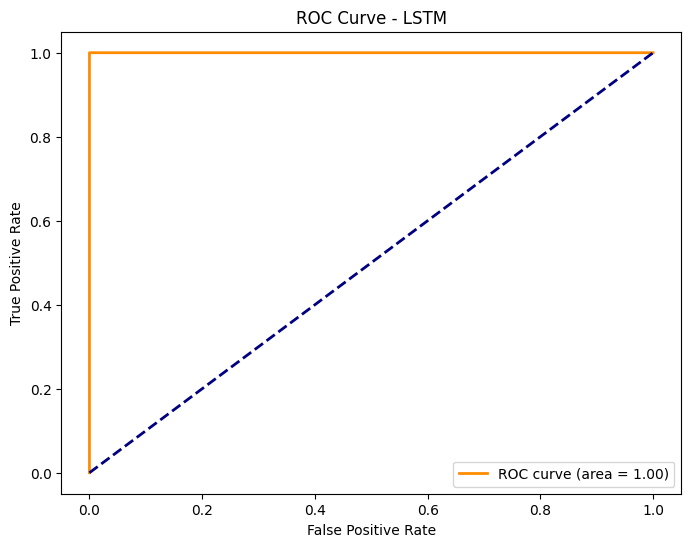

In [39]:
# Plot ROC curve
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_proba_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend(loc="lower right")
plt.show()

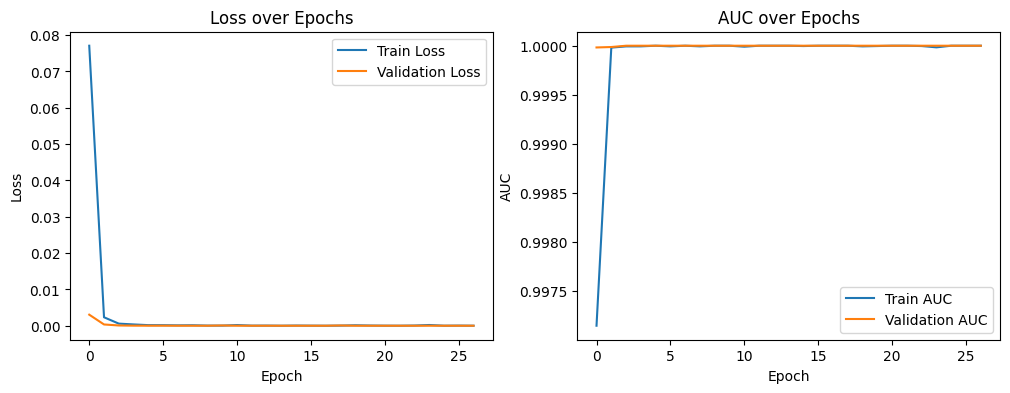

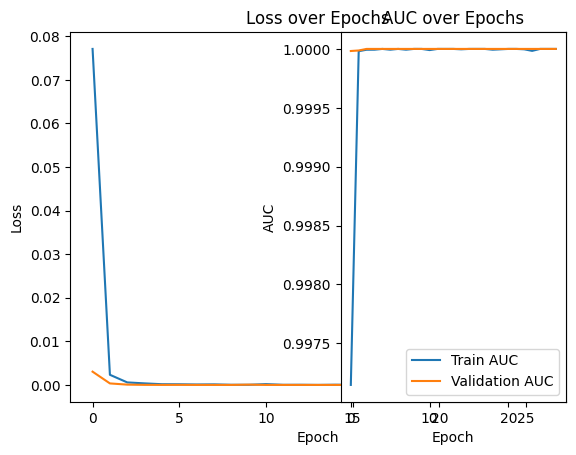

In [40]:
# Plot training history (optional)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['auc'], label='Train AUC')
plt.plot(history_lstm.history['val_auc'], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['auc'], label='Train AUC')
plt.plot(history_lstm.history['val_auc'], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [41]:
# Calculate the confusion matrix
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)

# Print the confusion matrix
print("Confusion Matrix for LSTM:")
print(conf_matrix_lstm)

Confusion Matrix for LSTM:
[[47781     0]
 [    0 47692]]


In [42]:
# Extract TN, FP, FN, TP from the confusion matrix
# The confusion matrix structure for binary classification in sklearn is:
# [[TN, FP],
#  [FN, TP]]
tn, fp, fn, tp = conf_matrix_lstm.ravel()

# Print the values
print("\nConfusion Matrix Components:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


Confusion Matrix Components:
True Negatives (TN): 47781
False Positives (FP): 0
False Negatives (FN): 0
True Positives (TP): 47692


# **Feature Importance**

In [ ]:
!pip install shap

The feature importance code is very compute expensive and time consuming. With GPU ON, the below code ran for more than 60 min.

In [ ]:
# Split the scaled data (before reshaping)
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

# Reshape the training and testing data for LSTM
# LSTMs expect input in the format (samples, time steps, features)
x_train = X_scaled_train.reshape((X_scaled_train.shape[0], 1, X_scaled_train.shape[1]))
x_test = X_scaled_test.reshape((X_scaled_test.shape[0], 1, X_scaled_test.shape[1]))

# --- Build the LSTM Model ---

# Define the model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])), # LSTM layer
    Dropout(0.3),
    LSTM(32), # Another LSTM layer, return_sequences=False for the last LSTM layer
    Dropout(0.3),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the model
model_lstm.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=[tf.keras.metrics.AUC(name='auc')])

# Print model summary
model_lstm.summary()

# --- Train the LSTM Model ---

# Calculate balance_weight if needed (similar to your MLP)
benign_count = y_train.value_counts()[0]
anomaly_count = y_train.value_counts()[1]
balance_weight = benign_count / anomaly_count if anomaly_count > 0 else 1.0
class_weights = {0: 1, 1: balance_weight}

print(f"Balance Weight: {balance_weight}")

history_lstm = model_lstm.fit(x_train, y_train,
                              epochs=50, # Adjust epochs
                              batch_size=256, # Adjust batch size
                              validation_split=0.2,
                              class_weight=class_weights,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# %%
# --- Evaluate the LSTM Model ---

loss_lstm, auc_lstm = model_lstm.evaluate(x_test, y_test, verbose=0)
print(f"--- LSTM Classifier ---")
print(f"Test AUC: {auc_lstm:.4f}")

# %%
# Get predictions and probabilities
y_pred_proba_lstm = model_lstm.predict(x_test).ravel()
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_lstm))

# %%
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_lstm))

# %%
# Plot ROC curve
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_proba_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend(loc="lower right")
plt.show()

# %%
# Plot training history (optional)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['auc'], label='Train AUC')
plt.plot(history_lstm.history['val_auc'], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['auc'], label='Train AUC')
plt.plot(history_lstm.history['val_auc'], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()
# %%
# Calculate the confusion matrix
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)

# Print the confusion matrix
print("Confusion Matrix for LSTM:")
print(conf_matrix_lstm)
# %%
# Extract TN, FP, FN, TP from the confusion matrix
# The confusion matrix structure for binary classification in sklearn is:
# [[TN, FP],
#  [FN, TP]]
tn, fp, fn, tp = conf_matrix_lstm.ravel()

# Print the values
print("\nConfusion Matrix Components:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# %% [markdown]
# Feature Importance
# %%
!pip install shap
# %%
import shap

# SHAP requires an "explainer" which is model-specific.
# For deep learning models like LSTMs, KernelExplainer or DeepExplainer can be used.
# DeepExplainer is typically faster for deep networks but requires specific conditions.
# KernelExplainer is model-agnostic but can be slower.

# Let's try KernelExplainer first as it's more general.
# KernelExplainer requires a background dataset (e.g., a small sample of your training data).
# You'll also need a prediction function that takes the data in its original format
# (before reshaping for LSTM) and returns the model's output.

# Create a background dataset (e.g., a sample of the scaled training data)
# You need the scaled training data before reshaping for LSTM.
# Let's assume you have X_scaled_train.
# If not, split X_scaled initially into X_scaled_train and X_scaled_test.

# Assuming X_scaled_train is available:
background_data = shap.sample(X_scaled_train, 100) # Use a small sample for speed

# Define a prediction function that takes the data in its original format (before reshaping)
# and reshapes it for the model prediction
def predict_proba_reshape(X_input):
    X_reshaped_input = X_input.reshape((-1, 1, X_input.shape[1]))
    return model_lstm.predict(X_reshaped_input)


# Create the explainer
# This can take some time
explainer = shap.KernelExplainer(predict_proba_reshape, background_data)

# Calculate SHAP values for the test set
# This can also take a significant amount of time depending on the size of your test set
shap_values = explainer.shap_values(X_scaled_test)

# Plot global feature importance (Mean absolute SHAP value)
# For binary classification, shap_values is a list with an array for each class.
# We typically plot the shap_values for the positive class (index 1).
# If you want to plot for both classes, you can adjust this.
shap.summary_plot(shap_values[1], features=X_scaled_test, feature_names=X.columns.tolist())